In [1]:
import scipy

import pandas as pd
import numpy as np
import json
import re

#Plotting
import matplotlib.pyplot as plt
import FCPython 

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import glob

In [2]:
# Importiere Datensatz Schüsse
shots_model = pd.read_csv('shots_model.csv', index_col=0)
shots_model = shots_model.reset_index(drop=True)
shots_model

,Goal,X,Y,C,matchId,teamId,eventSec,Distance,Angle
0,1,6,57,7.0,2500686.0,3799.0,605.975493,7.530106,0.792427
1,1,4,43,7.0,2500686.0,3772.0,1568.104834,6.058259,0.898499
2,0,16,21,29.0,2500686.0,3772.0,1800.852078,24.724937,0.193428
3,0,27,51,1.0,2500686.0,3799.0,2009.537139,27.007823,0.269317
4,0,28,59,9.0,2500686.0,3799.0,2072.957133,28.604589,0.249363
...,...,...,...,...,...,...,...,...,...
36086,0,14,40,10.0,2500098.0,1633.0,1933.702081,15.435349,0.427635
36087,0,28,45,5.0,2500098.0,1633.0,1972.969422,28.187985,0.256593
36088,1,14,33,17.0,2500098.0,1633.0,2193.887080,17.835428,0.324439
36089,0,12,62,12.0,2500098.0,1623.0,2377.197700,14.312233,0.430171


In [3]:
# Histogramm zweidimensional
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])

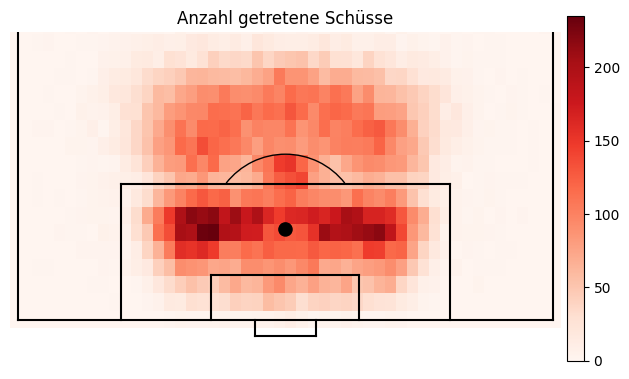

In [2097]:
# Anzahl Schüsse pro Cluster 
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax, fraction=0.03, pad=0.01)
ax.set_title('Anzahl getretene Schüsse')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
#plt.show()
fig.savefig('Output/NumberOfShots.pdf', dpi=None, bbox_inches="tight") 

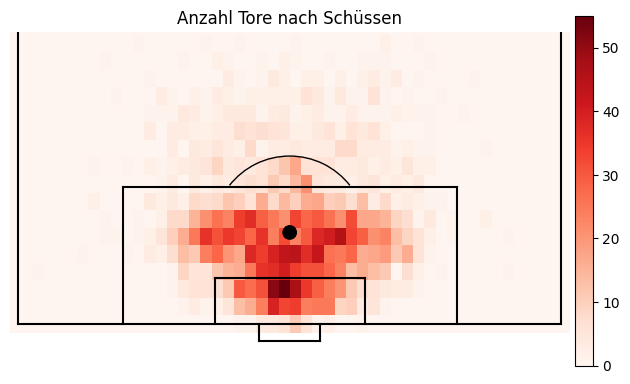

In [2098]:
# Tore pro Cluster 
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax, fraction=0.03, pad=0.01)
ax.set_title('Anzahl Tore nach Schüssen')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
#plt.show()
fig.savefig('Output/NumberOfGoals.pdf', dpi=None, bbox_inches="tight")  

/var/folders/rb/910_c2gs4n50kzjbpsbr8mhc0000gn/T/ipykernel_37639/3022028403.py:3: RuntimeWarning: invalid value encountered in divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)


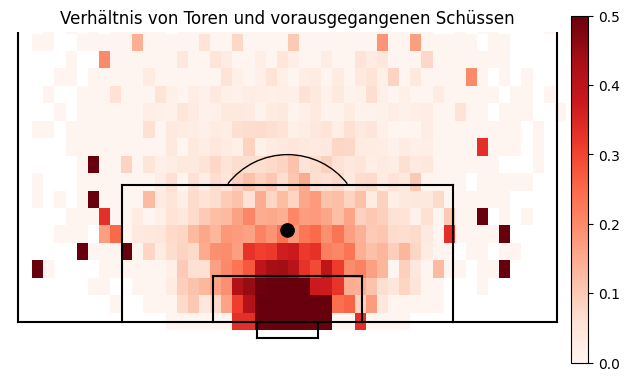

In [2099]:
# empirische Torwahrscheinlichkeit pro Cluster 
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax, fraction=0.03, pad=0.01)
ax.set_title('Verhältnis von Toren und vorausgegangenen Schüssen')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/ProbabilityOfScoring.pdf', dpi=None, bbox_inches="tight") 

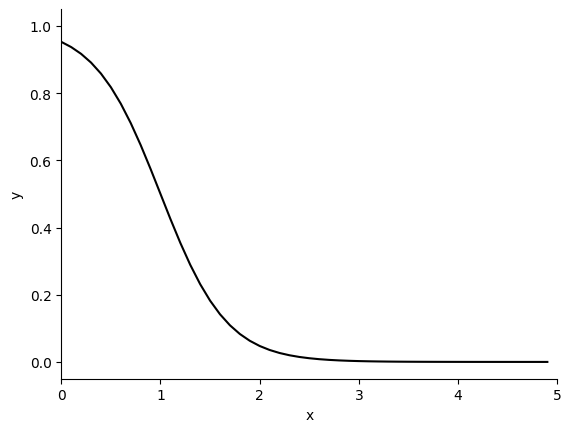

In [2100]:
# logistische Kurve zum Vergleich, dass so Modell anpassbar 
b=[3, -3]
x=np.arange(5,step=0.1)
y=1/(1+np.exp(-b[0]-b[1]*x))
fig,ax=plt.subplots(num=1)
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x") 
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

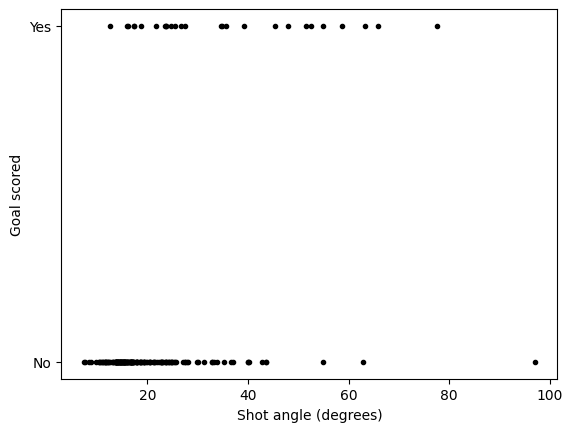

In [2101]:
# 200 Schüsse
shots_200=shots_model.iloc[:200]

# Plotte diese in Abhängigkeit vom Winkel 

fig,ax=plt.subplots(num=1)
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

/var/folders/rb/910_c2gs4n50kzjbpsbr8mhc0000gn/T/ipykernel_37639/3125051010.py:6: RuntimeWarning: invalid value encountered in divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


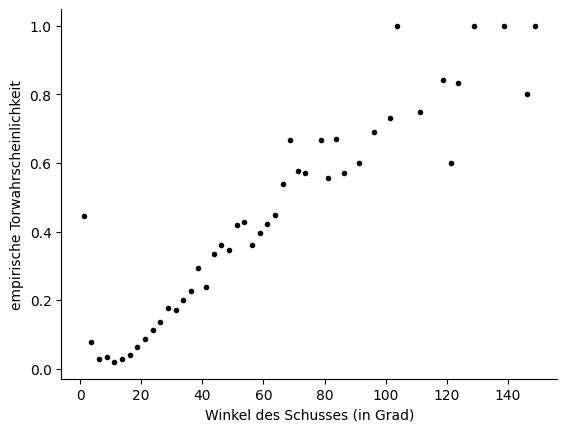

In [2102]:
# Winkel sagt Torwahrscheinlichkeit vorher empirisch 

shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=60,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=60,range=[0, 150])
with np.errstate(divide='ignore'):
    prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('empirische Torwahrscheinlichkeit')
ax.set_xlabel("Winkel des Schusses (in Grad)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


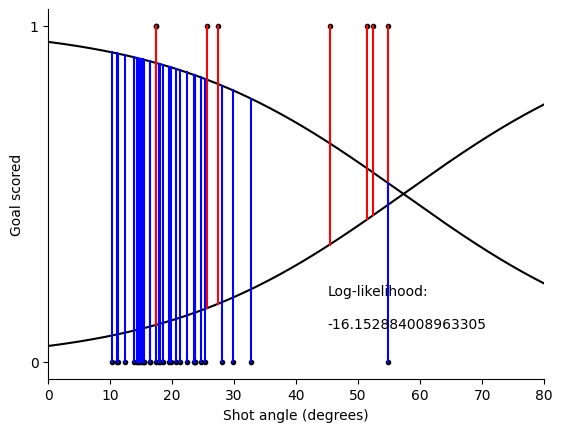

In [2104]:
# Likelihood der gegebenen Daten 

xG=1/(1+np.exp(b[0]+b[1]*shots_model['Angle'])) 
shots_model = shots_model.assign(xG=xG)
shots_40=shots_model.iloc[:40]
fig,ax=plt.subplots(num=1)
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', color='black')
ax.plot(x, y, linestyle='solid', color='black')
ax.plot(x, 1-y, linestyle='solid', color='black')
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang=shot['Angle']*180/np.pi
    if shot['Goal']==1:
        loglikelihood=loglikelihood+np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],shot['xG']], color='red')
    else:
        loglikelihood=loglikelihood+np.log(1 - shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='blue')
    
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,80))
plt.text(45,0.2,'Log-likelihood:') 
plt.text(45,0.1,str(loglikelihood))
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('Output/LikelihoodExample.pdf', dpi=None, bbox_inches="tight")   
plt.show()

In [2105]:
# Modell mit einer Variable Winkel 
# logistische Regression 


# hier wird NUR der Winkel berücksichtigt 

test_model = smf.glm(formula="Goal ~ Angle" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                36091
Model:                            GLM   Df Residuals:                    36089
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10068.
Date:                Wed, 13 Dec 2023   Deviance:                       20136.
Time:                        22:07:32   Pearson chi2:                 3.40e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08922
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8372      0.039    -97.842      0.0

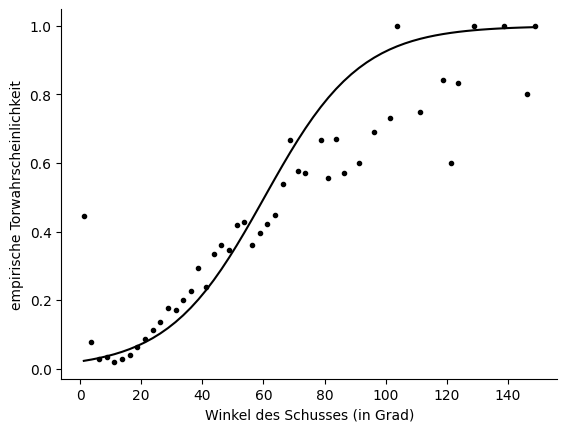

In [2107]:
# Fit des Modells 

xGprob=1/(1+np.exp(-b[0]-b[1]*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('empirische Torwahrscheinlichkeit')
ax.set_xlabel("Winkel des Schusses (in Grad)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
fig.savefig('Output/ProbabilityOfScoringAngleFit.pdf', dpi=None, bbox_inches="tight") 

/var/folders/rb/910_c2gs4n50kzjbpsbr8mhc0000gn/T/ipykernel_37639/3244562395.py:9: RuntimeWarning: invalid value encountered in divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


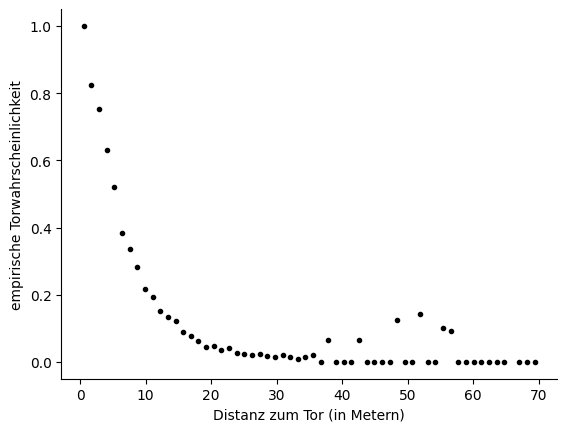

In [2108]:
# Jetzt Distanz 

# Distanz sagt TWkt voraus empirisch 


shotcount_dist=np.histogram(shots_model['Distance'],bins=60,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=60,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('empirische Torwahrscheinlichkeit')
ax.set_xlabel("Distanz zum Tor (in Metern)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [2109]:
# Modell nur Distanz 

test_model = smf.glm(formula="Goal ~ Distance" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())     
reduced_ll = test_model.llf   
b=test_model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                36091
Model:                            GLM   Df Residuals:                    36089
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9912.8
Date:                Wed, 13 Dec 2023   Deviance:                       19826.
Time:                        22:07:33   Pearson chi2:                 3.36e+07
No. Iterations:                     7   Pseudo R-squ. (CS):            0.09701
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5966      0.049     12.139      0.0

In [2110]:

xGprob=1/(1+np.exp(-b[0]-b[1]*middistance)) 
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()
fig.savefig('Output/ProbabilityOfScoringDistance.pdf', dpi=None, bbox_inches="tight") 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                36091
Model:                            GLM   Df Residuals:                    36088
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9819.6
Date:                Wed, 13 Dec 2023   Deviance:                       19639.
Time:                        22:07:33   Pearson chi2:                 3.86e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1017
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1643      0.058     20.009      0.0

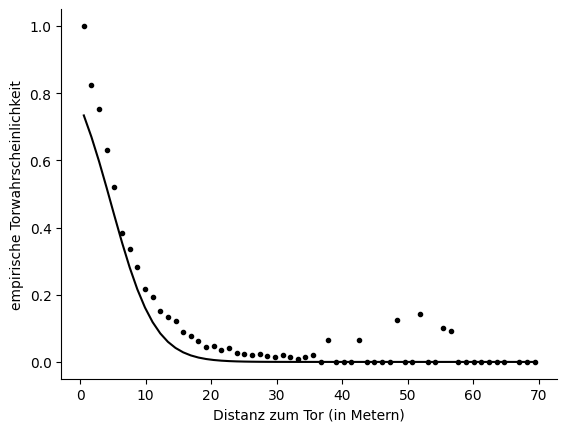

In [2111]:
# jetzt mit quadrierter Distanz 


squaredD = shots_model['Distance']**2
shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
full_ll = test_model.llf
b=test_model.params
xGprob=1/(1+np.exp(-b[0]-b[1]*middistance+b[2]*pow(middistance,2))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('empirische Torwahrscheinlichkeit')
ax.set_xlabel("Distanz zum Tor (in Metern)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()
fig.savefig('Output/ProbabilityOfScoringDistanceSquared.pdf', dpi=None, bbox_inches="tight") 

In [2112]:
# Log-Likelihood
print(reduced_ll)
print(full_ll)

-9912.783629413729
-9819.618500672326


In [2113]:
#berechne likelihood ratio Chi-Squared Teststatistik
LR_statistic = -2*(reduced_ll-full_ll)

print(LR_statistic)

#calculate p-value of test statistic using 2 degrees of freedom
p_val = scipy.stats.chi2.sf(LR_statistic, 1)

print(p_val)


186.33025748280488
2.0109290482233678e-42


In [2114]:
# Modellauswahl 
model_variables = ['Angle', 'Distance', 'D2']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

model

'Angle + Distance + D2'

In [2115]:
shots_model.head()

,Goal,X,Y,C,matchId,teamId,eventSec,Distance,Angle,xG,D2
0,1,6,57,7.0,2500686.0,3799.0,605.975493,7.530106,0.792427,0.349163,56.7025
1,1,4,43,7.0,2500686.0,3772.0,1568.104834,6.058259,0.898499,0.424457,36.7025
2,0,16,21,29.0,2500686.0,3772.0,1800.852078,24.724937,0.193428,0.081682,611.3225
3,0,27,51,1.0,2500686.0,3799.0,2009.537139,27.007823,0.269317,0.100467,729.4225
4,0,28,59,9.0,2500686.0,3799.0,2072.957133,28.604589,0.249363,0.095185,818.2225


In [2116]:
#Fit model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
b[0]

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                36091
Model:                            GLM   Df Residuals:                    36087
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9754.1
Date:                Wed, 13 Dec 2023   Deviance:                       19508.
Time:                        22:07:34   Pearson chi2:                 3.57e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1049
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2875      0.145     -1.982      0.0

-0.2875282783146246

In [2117]:
# berechnet xG für gegebenes Modell oben an 
def calculate_xG(sh):    
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(-bsum)) 
   return xG 

In [2118]:
# fügt xG zu df hinzu 
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)
shots_model

,Goal,X,Y,C,matchId,teamId,eventSec,Distance,Angle,xG,D2
0,1,6,57,7.0,2500686.0,3799.0,605.975493,7.530106,0.792427,0.343090,56.7025
1,1,4,43,7.0,2500686.0,3772.0,1568.104834,6.058259,0.898499,0.428836,36.7025
2,0,16,21,29.0,2500686.0,3772.0,1800.852078,24.724937,0.193428,0.027492,611.3225
3,0,27,51,1.0,2500686.0,3799.0,2009.537139,27.007823,0.269317,0.024338,729.4225
4,0,28,59,9.0,2500686.0,3799.0,2072.957133,28.604589,0.249363,0.020760,818.2225
...,...,...,...,...,...,...,...,...,...,...,...
36086,0,14,40,10.0,2500098.0,1633.0,1933.702081,15.435349,0.427635,0.097450,238.2500
36087,0,28,45,5.0,2500098.0,1633.0,1972.969422,28.187985,0.256593,0.021673,794.5625
36088,1,14,33,17.0,2500098.0,1633.0,2193.887080,17.835428,0.324439,0.065880,318.1025
36089,0,12,62,12.0,2500098.0,1623.0,2377.197700,14.312233,0.430171,0.111690,204.8400


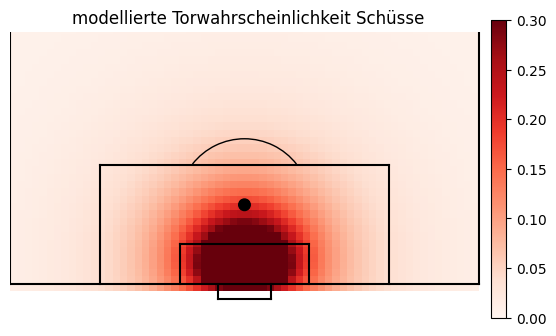

In [2119]:
# 2D Map der xG 
pgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax, fraction=0.03, pad=0.01)
ax.set_title('modellierte Torwahrscheinlichkeit Schüsse')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/goalprobfor_' + model  + '.pdf', dpi=None, bbox_inches="tight")   

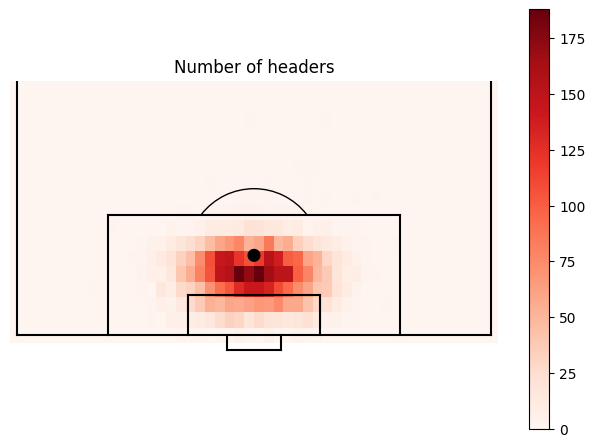

In [2120]:
## das gleiche Spiel nochmal grob für Kopfbälle; dass hier Distanz und Winkel ebenfalls eine Rolle spielen, ist einigermaßen logisch; evtl. später überarbeiten 
header_model = pd.read_csv('header_model.csv', index_col=0)
#2D Hist.
H_Shot=np.histogram2d(header_model['X'], header_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=header_model[header_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])

# Nummer Kopfbälle 
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of headers')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
#plt.show()
fig.savefig('Output/NumberOfHeaders.pdf', dpi=None, bbox_inches="tight") 

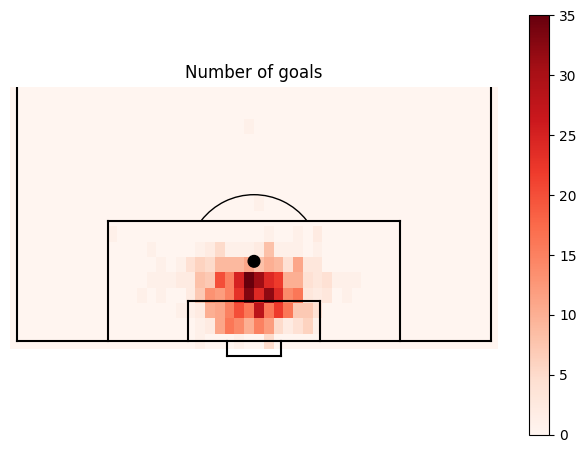

In [2121]:
# Nummer Tore nach Kopfball
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
#plt.show()
fig.savefig('Output/NumberOfGoalsHeaders.pdf', dpi=None, bbox_inches="tight")  

/var/folders/rb/910_c2gs4n50kzjbpsbr8mhc0000gn/T/ipykernel_37639/792184408.py:3: RuntimeWarning: invalid value encountered in divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)


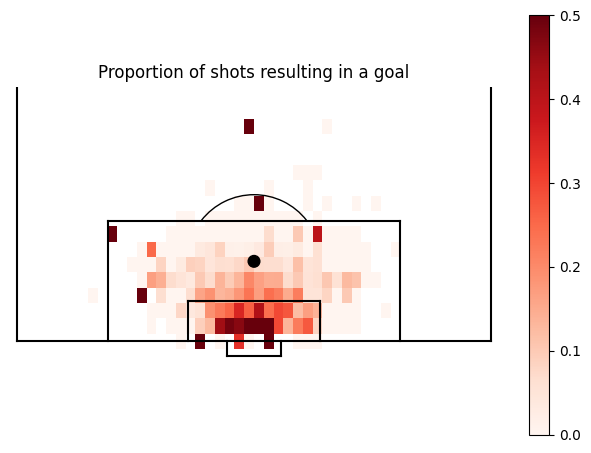

In [2122]:
# empirische Torwkt. für Kopfbälle 
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/ProbabilityOfScoringHeaders.pdf', dpi=None, bbox_inches="tight") 

In [2123]:
model_variables = ['Angle','Distance', 'D2']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

model

'Angle + Distance + D2'

In [2124]:
squaredD = header_model['Distance']**2
header_model = header_model.assign(D2=squaredD)

In [2125]:
header_model.head()

,Goal,X,Y,C,matchId,teamId,eventSec,Distance,Angle,D2
0,0,17,42,8.0,2500686.0,3772.0,859.236394,17.777514,0.390103,316.0400
1,0,5,45,5.0,2500687.0,3770.0,1234.432647,5.963430,1.026231,35.5625
2,0,6,44,6.0,2500687.0,3776.0,1644.963852,7.156116,0.859960,51.2100
3,0,9,46,4.0,2500688.0,3766.0,567.951667,9.368031,0.724975,87.7600
4,0,3,35,15.0,2500688.0,3779.0,2741.688664,10.201103,0.237629,104.0625


In [2126]:
#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=header_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
b[0]

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                 6987
Model:                            GLM   Df Residuals:                     6983
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2389.4
Date:                Wed, 13 Dec 2023   Deviance:                       4778.7
Time:                        22:07:35   Pearson chi2:                 7.35e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06703
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0871      0.467     -0.187      0.8

-0.0871018613976243

In [2127]:
# wieder xG calculaten für Kopfbälle 
def calculate_xG_head(sh):    
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(-bsum)) 
   return xG 

In [2128]:
xGh=header_model.apply(calculate_xG_head, axis=1) 
header_model = header_model.assign(xG=xGh)
header_model

,Goal,X,Y,C,matchId,teamId,eventSec,Distance,Angle,D2,xG
0,0,17,42,8.0,2500686.0,3772.0,859.236394,17.777514,0.390103,316.0400,0.019080
1,0,5,45,5.0,2500687.0,3770.0,1234.432647,5.963430,1.026231,35.5625,0.253566
2,0,6,44,6.0,2500687.0,3776.0,1644.963852,7.156116,0.859960,51.2100,0.188121
3,0,9,46,4.0,2500688.0,3766.0,567.951667,9.368031,0.724975,87.7600,0.113780
4,0,3,35,15.0,2500688.0,3779.0,2741.688664,10.201103,0.237629,104.0625,0.074956
...,...,...,...,...,...,...,...,...,...,...,...
6982,0,5,38,12.0,2500097.0,1624.0,1371.188671,9.264988,0.467811,85.8400,0.102128
6983,0,7,62,12.0,2500097.0,1631.0,1760.720664,10.480458,0.488366,109.8400,0.080635
6984,0,4,61,11.0,2500097.0,1631.0,2330.151552,8.192832,0.498980,67.1225,0.129011
6985,0,7,56,6.0,2500098.0,1623.0,2404.202827,8.013114,0.789568,64.2100,0.153874


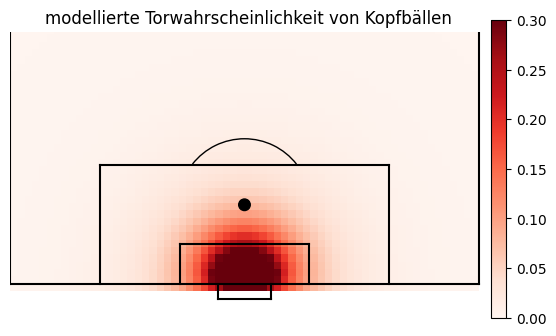

In [2129]:
# 2D Maps Kopfbälle 
pgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG_head(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax, fraction=0.03, pad=0.01)
ax.set_title('modellierte Torwahrscheinlichkeit von Kopfbällen')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/goalprobfor_' + model  + 'OfHeaders.pdf', dpi=None, bbox_inches="tight")   

In [2130]:
penalty_model = pd.read_csv('penalty_model.csv', index_col=0)
penalty_model['xG'] = 0.76
penalty_model

,Goal,X,Y,C,matchId,teamId,eventSec,Distance,Angle,xG
0,1,11,51,1.0,2500687.0,3776.0,1320.610031,11.019188,0.640531,0.76
1,1,10,50,0.0,2500688.0,3766.0,808.741059,10.000000,0.701714,0.76
2,1,11,50,0.0,2500690.0,3785.0,2315.627895,11.000000,0.642410,0.76
3,1,11,49,1.0,2500702.0,3775.0,1037.810326,11.019188,0.640531,0.76
4,1,10,50,0.0,2500704.0,3779.0,2212.923904,10.000000,0.701714,0.76
...,...,...,...,...,...,...,...,...,...,...
653,1,10,51,1.0,2500061.0,1651.0,272.924404,10.021103,0.699316,0.76
654,0,10,50,0.0,2500065.0,1625.0,1082.506055,10.000000,0.701714,0.76
655,1,10,50,0.0,2500070.0,1628.0,2667.504741,10.000000,0.701714,0.76
656,0,10,51,1.0,2500087.0,1644.0,2324.175519,10.021103,0.699316,0.76


In [2131]:
penalty_model[penalty_model['Goal']==1]
sum(penalty_model['Goal'])/658 # dies wäre der empirische xG Wert; hier evtl auf Quellen mit größerer Stichprobe verlassen

0.7249240121580547

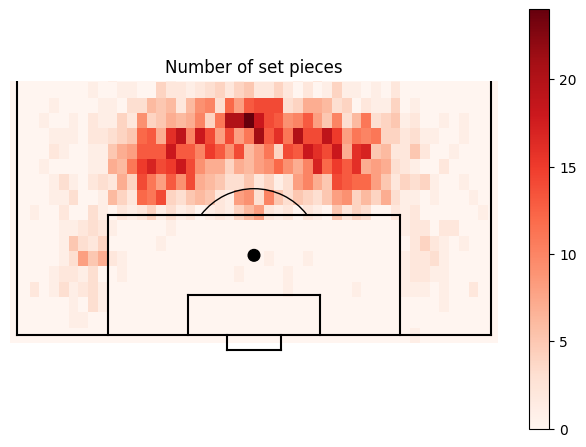

In [2132]:
# test set pieces 

set_piece_model = pd.read_csv('set_piece_model.csv', index_col=0)

#Two dimensional histogram
H_Shot=np.histogram2d(set_piece_model['X'], set_piece_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=set_piece_model[set_piece_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])

#Plot the number of shots from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of set pieces')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
#plt.show()
fig.savefig('Output/NumberOfSetPieces.pdf', dpi=None, bbox_inches="tight") 

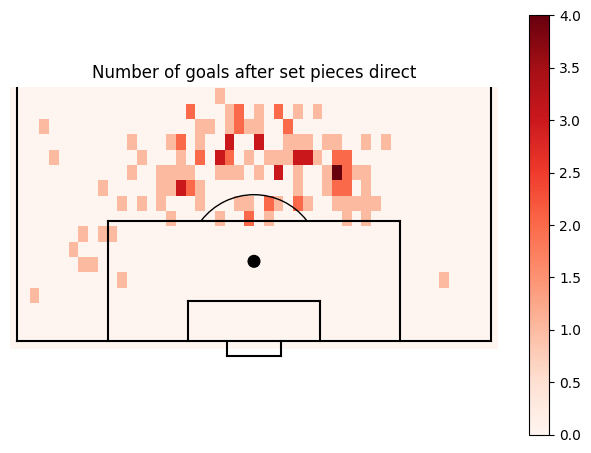

In [2133]:
# Standards
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals after set pieces direct')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
#plt.show()
fig.savefig('Output/NumberOfGoalsSetPieces.pdf', dpi=None, bbox_inches="tight") 

/var/folders/rb/910_c2gs4n50kzjbpsbr8mhc0000gn/T/ipykernel_37639/43073848.py:3: RuntimeWarning: invalid value encountered in divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)


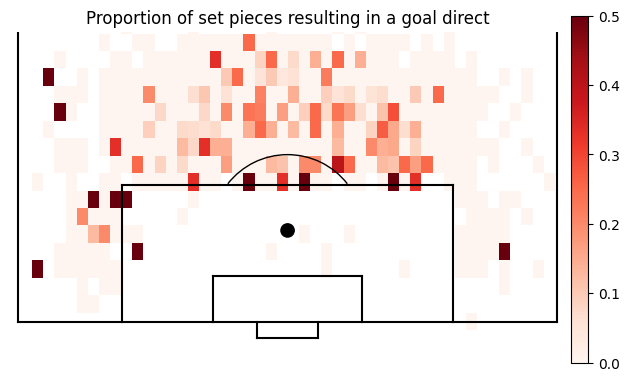

In [2134]:
#Plot the probability of scoring from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax, fraction=0.03, pad=0.01)
ax.set_title('Proportion of set pieces resulting in a goal direct')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/ProbabilityOfScoringSetPieces.pdf', dpi=None, bbox_inches="tight") 

In [2135]:
model_variables = ['Angle','Distance', 'D2']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

model

'Angle + Distance + D2'

In [2136]:
squaredD = set_piece_model['Distance']**2
set_piece_model = set_piece_model.assign(D2=squaredD)

In [2137]:
#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=set_piece_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
b[0]

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                 2204
Model:                            GLM   Df Residuals:                     2200
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -505.29
Date:                Wed, 13 Dec 2023   Deviance:                       1010.6
Time:                        22:07:36   Pearson chi2:                 2.21e+03
No. Iterations:                     7   Pseudo R-squ. (CS):           0.007191
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8100      2.070     -0.391      0.6

-0.810010148064396

In [2138]:
# wieder mit Standards
def calculate_xG_set_pieces(sh):    
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(-bsum)) 
   return xG 

In [2139]:
xGsp=set_piece_model.apply(calculate_xG_set_pieces, axis=1) 
set_piece_model = set_piece_model.assign(xG=xGsp)

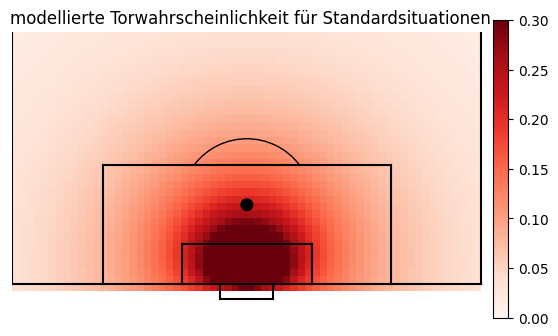

In [2140]:
# 2D Standards
pgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG_set_pieces(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax, fraction=0.03, pad=0.01)
ax.set_title('modellierte Torwahrscheinlichkeit für Standardsituationen')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/goalprobfor_' + model  + 'OfSetPieces.pdf', dpi=None, bbox_inches="tight")   

In [2141]:
# xG jeweils berechnen und abspeichern 
header_model.to_csv('xG_head.csv')
shots_model.to_csv('xG_shot.csv')
penalty_model.to_csv('xG_pen.csv')
set_piece_model.to_csv('xG_set_pieces.csv')
xG_df= pd.concat([shots_model, header_model, penalty_model, set_piece_model])
xG_df.reset_index(drop=True)
xG_df = xG_df.drop(columns=['D2'])
xG_df.to_csv('xG_full.csv')